<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/CLIPSeg/Zero_shot_image_segmentation_with_CLIPSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

Let's first install 🤗 Transformers. We install from source as the model is brand new at the moment of writing.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 7.6 MB 5.4 MB/s 
     |████████████████████████████████| 182 kB 52.5 MB/s 


## Load image

Next, let's load an image.

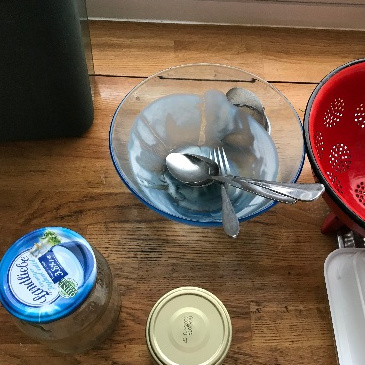

In [2]:
from PIL import Image
import requests

url = "https://github.com/timojl/clipseg/blob/master/example_image.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image

## Load model

Next, let's load the model and its processor from the [hub](https://huggingface.co/CIDAS/clipseg-rd64-refined).

In [3]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

Downloading:   0%|          | 0.00/368 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/974 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Downloading:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/603M [00:00<?, ?B/s]

## Prepare image and texts for model

The image and a few prompts can be prepared for the model using the processor.

In [4]:
prompts = ["a glass", "something to fill", "wood", "a jar"]

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")

## Forward pass

Next, let's run a forward pass and visualize the predictions the model made.

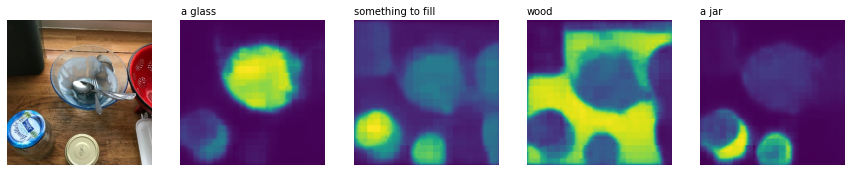

In [5]:
import torch
import matplotlib.pyplot as plt

# predict
with torch.no_grad():
  outputs = model(**inputs)

preds = outputs.logits.unsqueeze(1)

# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(4)];
[ax[i+1].text(0, -15, prompts[i]) for i in range(4)];

As can be seen, the model is capable of segmenting images based on text prompts in a zero-shot manner. Pretty cool, huh?

## Convert to binary mask

To convert to a binary mask, I borrow some logic from [here](https://github.com/amrrs/stable-diffusion-prompt-inpainting). One can apply a sigmoid activation function on the predicted mask and use some OpenCV (cv2) to turn it into a binary mask. 

In [28]:
filename = f"mask.png"
# here we save the second mask
plt.imsave(filename,torch.sigmoid(preds[1][0]))

In [29]:
import cv2

img2 = cv2.imread(filename)

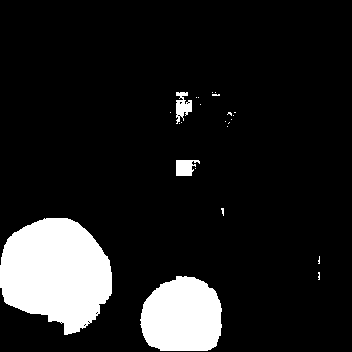

In [30]:
gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)